In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Fri Sep 12 14:43:54 PDT 2025
abie
/mnt/share/homes/abie/notebook/2025


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” state, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are no transitions between AD states during the simulation (since it’s an SI model and all simulants should be in the I state the whole time)
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
locations = ['united_states_of_america',
             'china'
            ]


results_dir_prefix = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

results_dirs = [
    results_dir_prefix + '/results/model4.0/united_states_of_america/2025_09_11_16_52_16/results/',
    results_dir_prefix + 'results/model4.0/china/2025_09_11_18_58_30/results/'
]

artifact_dirs = [results_dir_prefix + 'artifacts/model4.0/' + x + '.hdf' for x in locations]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model4.0/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model4.0/china.hdf']

In [3]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [4]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end
# age_dictionary.head()

## Verify that all simulants in the model have AD 

In [5]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        
        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [6]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [7]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [8]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        2.133893e+08
alzheimers_disease_state                      6.414232e+08
alzheimers_mild_cognitive_impairment_state    2.923464e+08
Name: value, dtype: float64

In [9]:
person_time.groupby(['current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity              alzheimers_blood_based_biomarker_state  \
current_year age_group                                           
2025         30_to_34                              6150.603696   
             35_to_39                              7452.271047   
             40_to_44                              6786.907598   
             45_to_49                             22856.336756   
             50_to_54                             50891.285421   
...                                                        ...   
2100         75_to_79                            521056.739220   
             80_to_84                            555554.932238   
             85_to_89                            426195.852156   
             90_to_94                            336972.517454   
             95_plus                             357021.100616   

sub_entity              alzheimers_disease_state  \
current_year age_group                             
2025         30_to_34               3.913018e+02   
             35_to_39               5.035318e+02   
             40_to_44               3.958111e+02   
             45_to_49               1.481536e+03   
             50_to_54               3.889971e+03   
...                                          ...   
2100         75_to_79               1.352748e+06   
             80_to_84               1.958185e+06   
             85_to_89               2.009446e+06   
             90_to_94               1.457635e+06   
             95_plus                1.214753e+06   

sub_entity              alzheimers_mild_cognitive_impairment_state  
current_year age_group                                              
2025         30_to_34                                  5212.180698  
             35_to_39                                  6164.131417  
             40_to_44                                  5864.517454  
             45_to_49                                 19321.092402  
             50_to_54                                 43896.952772  
...                                                            ...  
2100         75_to_79                                594275.277207  
             80_to_84                                742085.667351  
             85_to_89                                688127.597536  
             90_to_94                                558417.297741  
             95_plus                                 781308.041068  

[1064 rows x 3 columns]

In [10]:
assert np.all(person_time.groupby(['current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions between AD states during the simulation 

In [11]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [12]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [13]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 40.2 s, sys: 324 ms, total: 40.5 s
Wall time: 40.5 s


In [14]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,30 to 34,30_to_34,acmr,United_States_Of_America


In [15]:
art_data = art_ocmr
location = 'China'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [16]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        for year in [2030,2040,2050]:
            for i, sex in enumerate(sim_data.sex.unique()):
                color = f'C{i}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                plt.fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                plt.plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                plt.title(f"{measure} in {location} in {year}")
                plt.tick_params(axis='x', labelrotation=90)
                plt.xlabel("Age Group")
                plt.ylabel(f"{measure}")
                plt.legend()
#                 plt.semilogy()
            plt.figure()

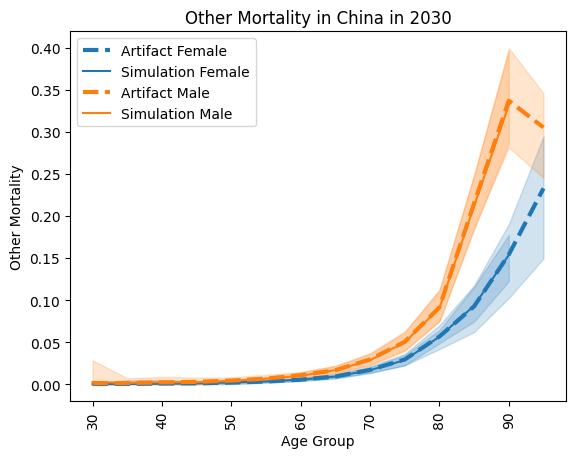

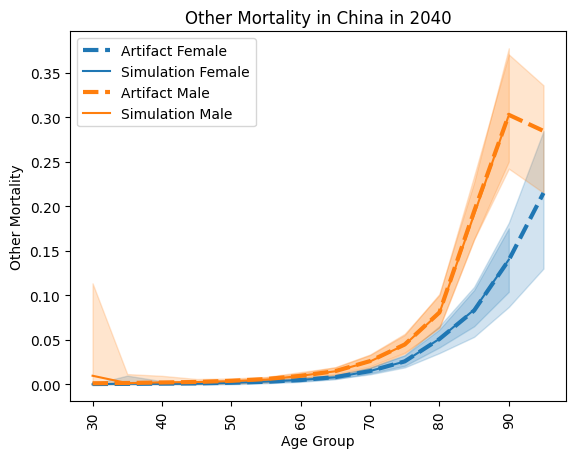

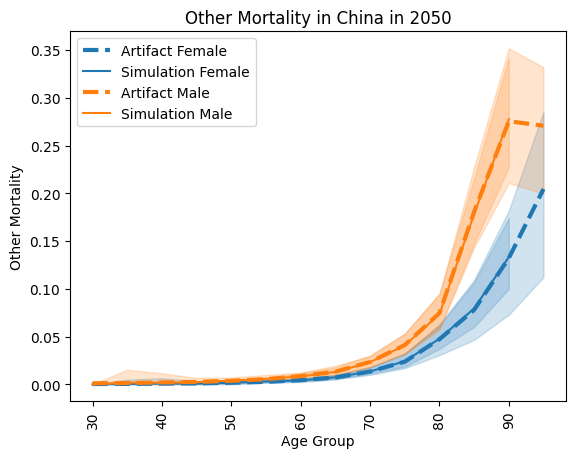

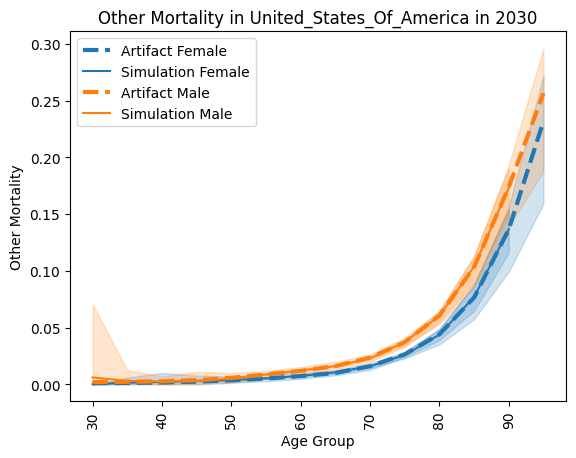

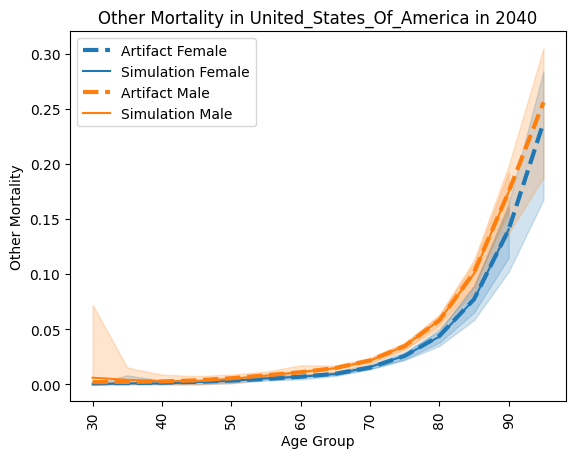

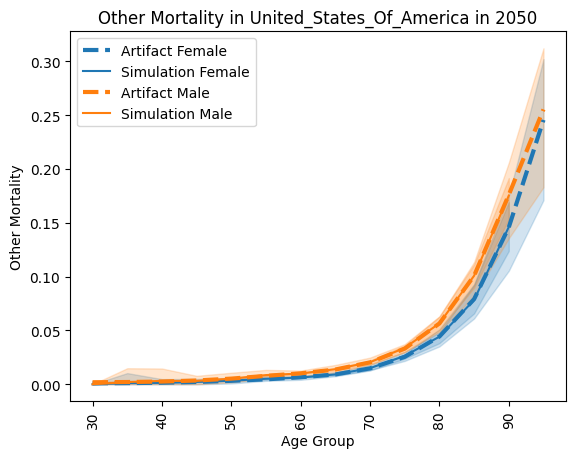

<Figure size 640x480 with 0 Axes>

In [17]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [18]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

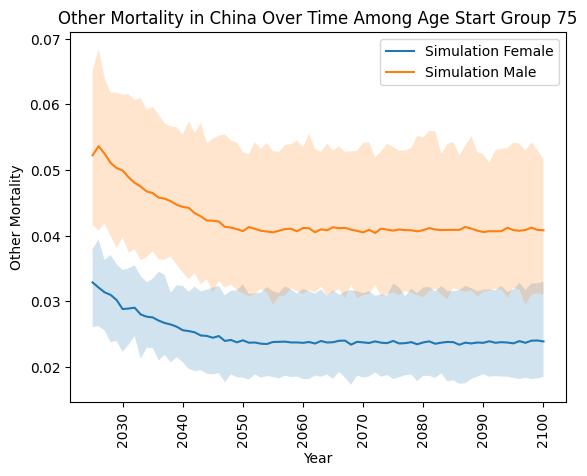

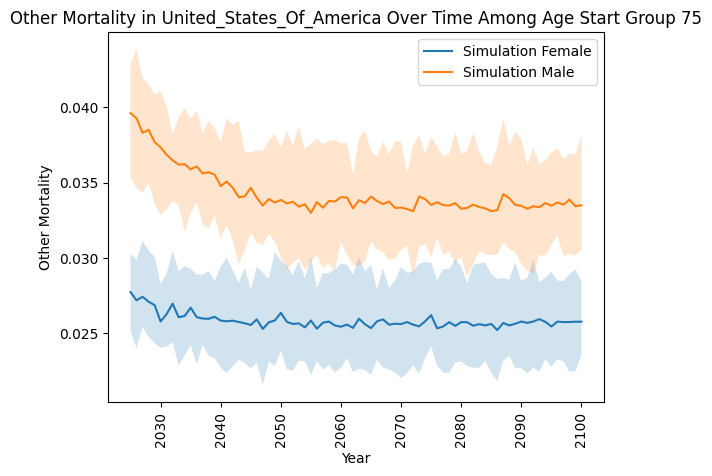

<Figure size 640x480 with 0 Axes>

In [19]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [20]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [21]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [22]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

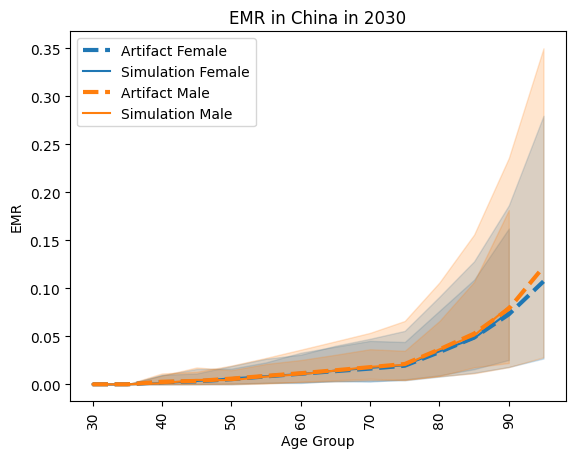

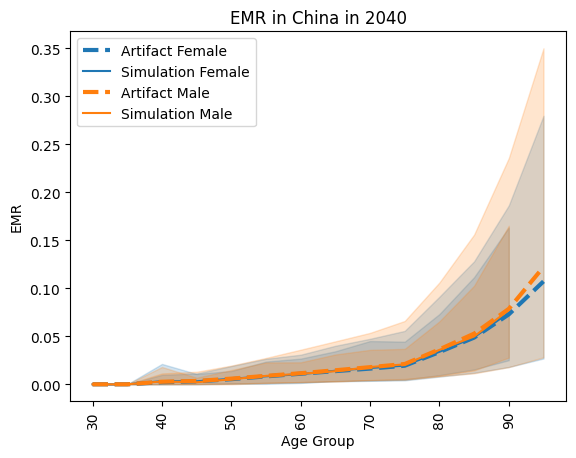

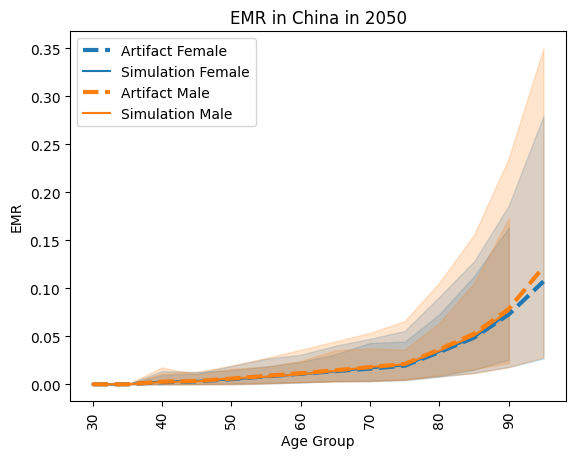

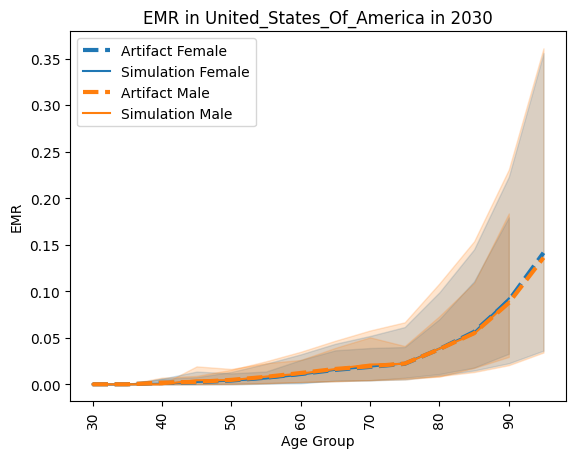

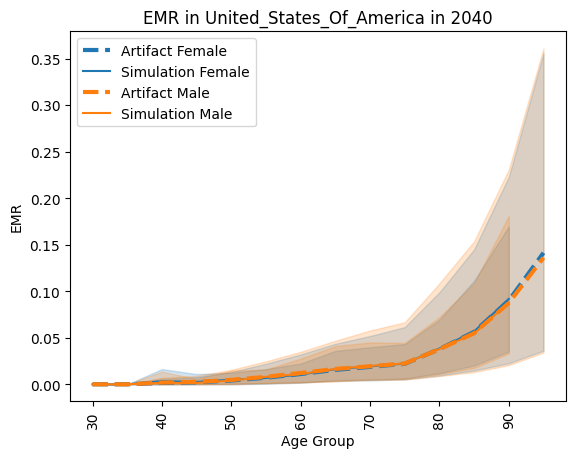

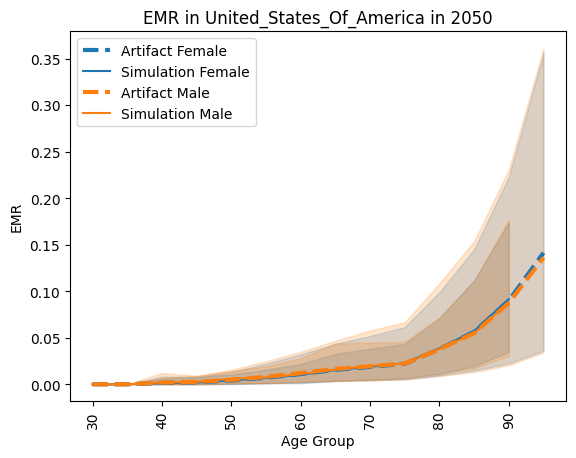

<Figure size 640x480 with 0 Axes>

In [23]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

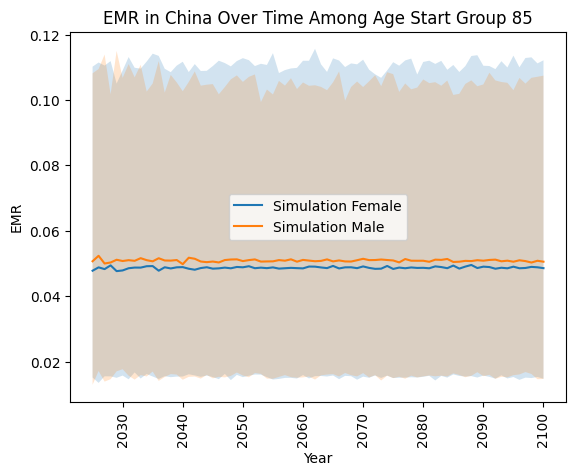

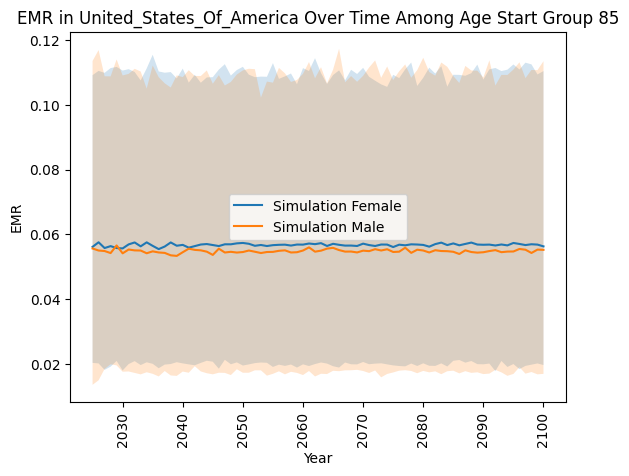

<Figure size 640x480 with 0 Axes>

In [24]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [25]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [26]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2021"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [27]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
China,168.0,0.000458,8.678785e-20,0.000458,0.000458,0.000458,0.000458,0.000458
United_States_Of_America,168.0,0.001677,3.471514e-19,0.001677,0.001677,0.001677,0.001677,0.001677


In [28]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
# new_sims

In [29]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [30]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [31]:
# new_sims

In [32]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [33]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,China,30_to_34,Female,25.0,6060.103678,2927.003408,0.000000,1833.748952,5239.282719,11963.028875,14844.634371,11,30 to 34,30.0,35.0
1,2025,China,30_to_34,Male,25.0,5658.425337,2986.531576,1309.820680,1571.784816,5675.889612,11002.493710,13098.206798,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,30_to_34,Female,25.0,1970.221176,861.475845,357.788349,572.461359,1908.204529,3935.671841,4651.248540,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,30_to_34,Male,25.0,1602.891804,784.388946,357.788349,429.346019,1550.416180,3291.652813,3577.883492,11,30 to 34,30.0,35.0
4,2026,China,30_to_34,Female,25.0,4313.676105,1929.321680,873.213787,1397.142058,4802.675826,7771.602700,8295.530972,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2049,United_States_Of_America,90_to_94,Male,25.0,77597.137176,14469.508518,61181.807715,62112.057422,73346.611588,109244.709291,119620.571418,32,90 to 94,90.0,95.0
1348,2050,China,90_to_94,Female,25.0,527490.984152,111790.456066,274189.128963,339156.234679,516069.347825,735420.650995,777596.876883,32,90 to 94,90.0,95.0
1349,2050,China,90_to_94,Male,25.0,66748.461840,44522.544177,10478.565438,15455.884021,64181.213308,171935.794563,203895.419149,32,90 to 94,90.0,95.0
1350,2050,United_States_Of_America,90_to_94,Female,25.0,125540.775970,18509.468665,97795.482117,98582.616485,124391.082741,168876.100826,169949.465874,32,90 to 94,90.0,95.0


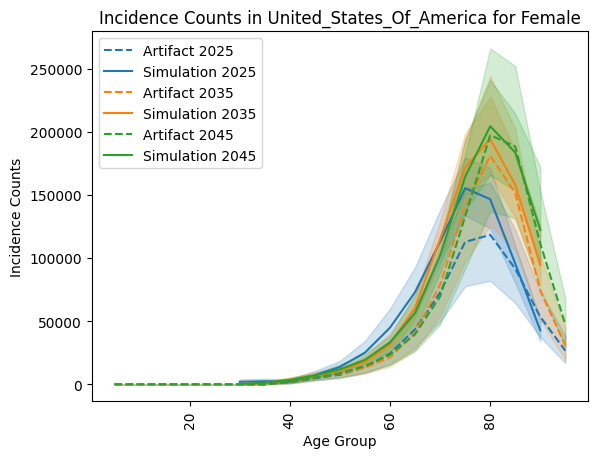

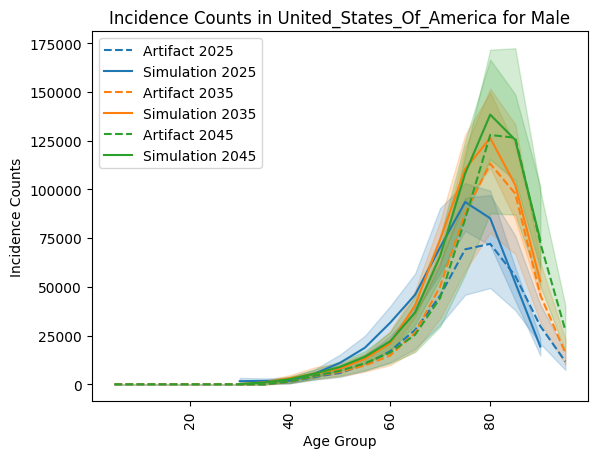

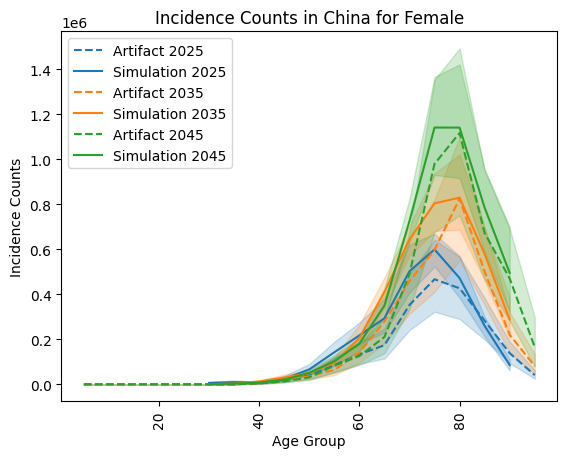

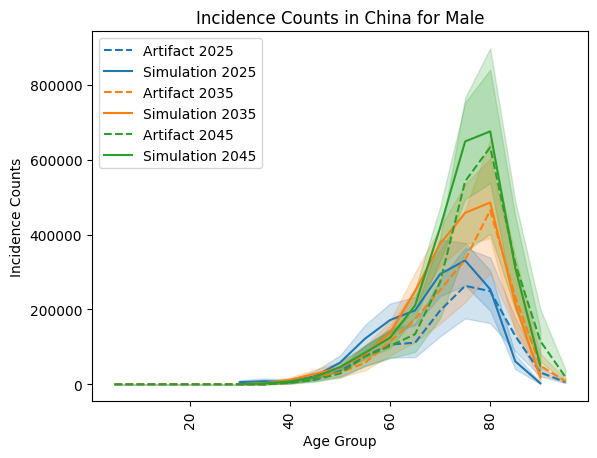

<Figure size 640x480 with 0 Axes>

In [34]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color=color)
            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)

            plt.title(f"Incidence Counts in {location} for {sex}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Incidence Counts")
            plt.legend()
        plt.figure()

## Verifying Prevalence

In [35]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   China                    2046       2047      119186.494913   
                                                  2047       2048      129281.025293   
                                                  2048       2049      141436.371360   
                                                  2049       2050      152654.031936   
                                                  2050       2051      160830.348491   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   China                    2046       2047      200433.203500   
                                                  2047       2048      218709.614231   
                                                  2048       2049      240709.691747   
                                                  2049       2050      261904.714261   
                                                  2050       2051      278933.840310   

                                                                             draw_10  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   China                    2046       2047      370477.436866   
                                                  2047       2048      413364.929897   
                                                  2048       2049      466284.779127   
                                                  2049       2050      520725.322419   
                                                  2050       2051      569000.434909   

                                                                            draw_100  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                        

In [36]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.head()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,China,30_to_34,Female,25.0,51940.405624,21182.903875,14656.364458,21087.664682,46375.362165,92269.470571,109594.605870,11,30 to 34,30.0,35.0
1,2025,China,30_to_34,Male,25.0,50085.391138,21379.317462,18156.391791,21306.416391,46594.113873,89906.952121,106313.330245,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,30_to_34,Female,25.0,15261.130206,5379.228426,5198.583899,7027.051340,15057.967157,26984.833206,32147.564803,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,30_to_34,Male,25.0,12942.681294,5030.070126,3465.722600,5437.599251,12309.290612,24283.959732,24857.596576,11,30 to 34,30.0,35.0
4,2026,China,30_to_34,Female,25.0,41694.075606,16418.283620,13125.102499,17193.884274,36969.038707,72888.069213,83781.904288,11,30 to 34,30.0,35.0


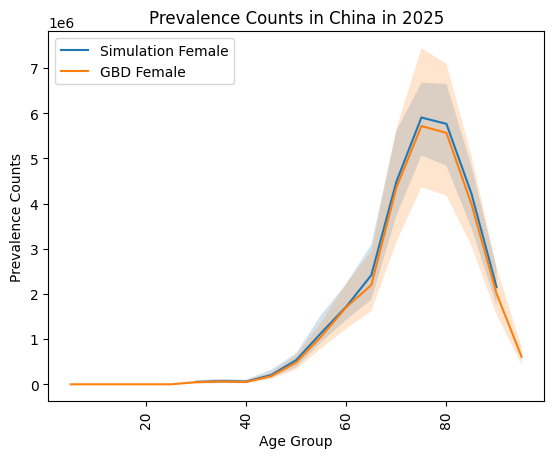

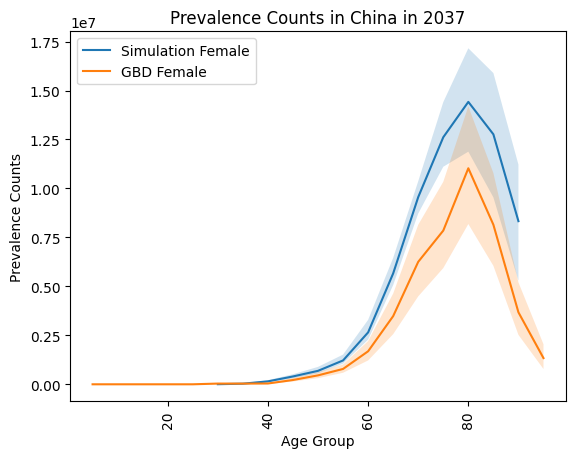

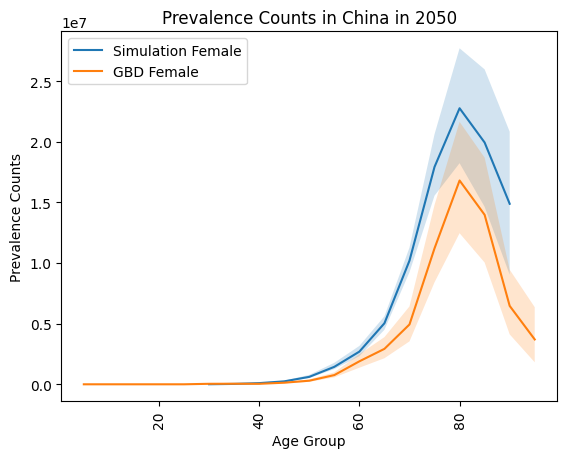

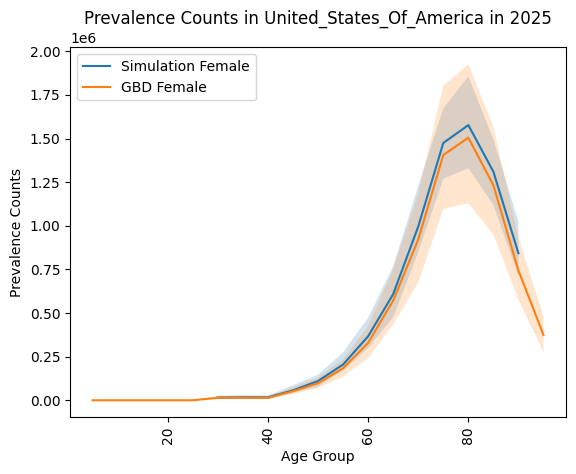

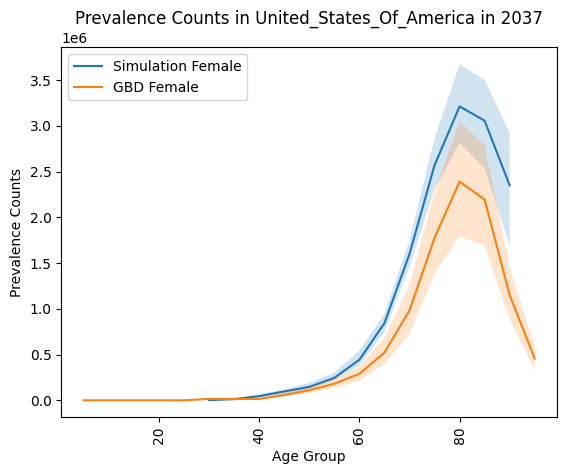

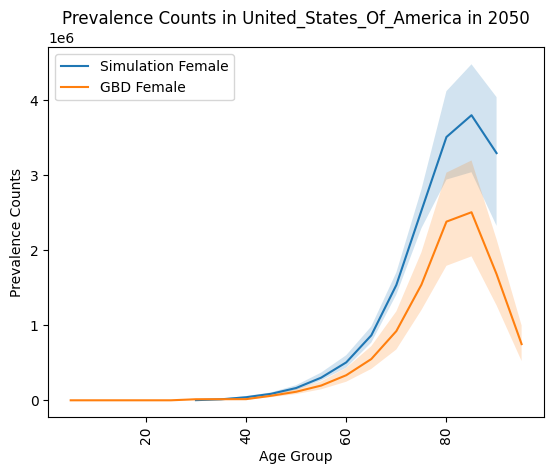

<Figure size 640x480 with 0 Axes>

In [37]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [38]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,25.0,104269.466940,473.408433,103194.464066,103289.158111,104370.874743,104981.526078,105067.802875
1,2025,United_States_Of_America,25.0,104289.928871,572.493928,103030.127310,103266.110883,104253.634497,105331.142505,105714.127310
2,2026,China,25.0,120114.436140,2237.900892,115255.679671,115764.622587,120877.700205,123573.724846,123966.028747
3,2026,United_States_Of_America,25.0,119960.260205,2667.666557,114283.186858,115305.882546,119789.470226,124915.073511,126955.655031
4,2027,China,25.0,135170.168049,3869.488691,127111.975359,127753.189322,136531.277207,140760.543737,140868.164271
...,...,...,...,...,...,...,...,...,...,...
147,2098,United_States_Of_America,25.0,279662.338563,28679.902479,225475.540041,229745.489938,289267.260780,316332.221766,318092.328542
148,2099,China,25.0,390029.761314,51447.929890,301646.127310,307637.705133,398494.587269,470834.023819,474925.708419
149,2099,United_States_Of_America,25.0,279653.540534,28625.480875,225516.123203,229755.710883,289492.221766,316404.570021,318074.792608
150,2100,China,25.0,389969.457741,51315.356221,301843.030801,307712.257906,398358.809035,470625.496509,474836.525667


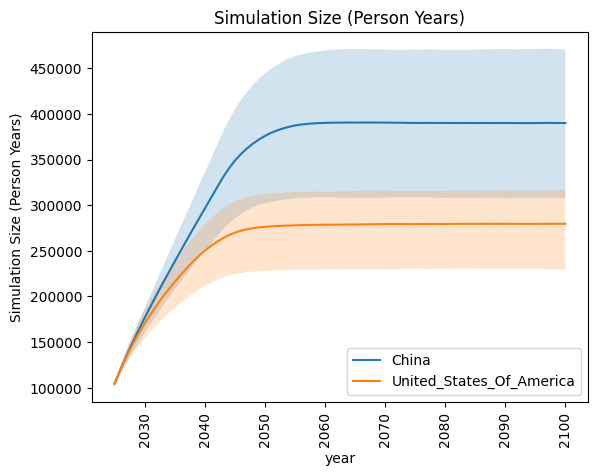

In [39]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()